# <center>  🎵 Mood Detection from Text + Music Recommendation </center> 
This deep learning NLP project classifies the **emotional tone of a sentence** and suggests a **music playlist** based on detected mood. It uses **LSTM (TensorFlow/Keras)** for sequence modeling and **GloVe embeddings** for semantic understanding.

###  What this project does:
- Detects emotions like joy, sadness, anger, fear, surprise, love from text
- Recommends matching music playlists (using Spotify-style mapping)
- Built fully by me to learn **text classification, embeddings, and real-world NLP**

###  Why it matters:
In the real world, mood-aware systems can personalize experiences in chatbots, mental health apps, music players, etc.


##  Step 1: Load Emotion Dataset

In [88]:
from datasets import load_dataset

In [89]:
ds = load_dataset('emotion')

In [90]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [91]:
label_names = ds['train'].features['label'].names

##  Step 2: Text Cleaning

In [92]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # FOR removing punctuatition
    text = re.sub(r'\s+', ' ', text).strip() #removing unwanted gaps
    return text


train_texts = [clean_text(t) for t in ds['train']['text']]
test_texts =  [clean_text(t) for t in ds['test']['text']]
val_texts =  [clean_text(t) for t in ds['validation']['text']]

In [93]:
train_texts[:10]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy',
 'ive been feeling a little burdened lately wasnt sure why that was',
 'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny',
 'i feel as confused about life as a teenager or as jaded as a year old man',
 'i have been with petronas for years i feel that petronas has performed well and made a huge profit',
 'i feel romantic too']

##  Step 3: Tokenization + Sequences

In [94]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [95]:
tokenizer = Tokenizer(oov_token="<OOV>")

tokenizer.fit_on_texts(train_texts) 

train_seq = tokenizer.texts_to_sequences(train_texts)  #Each word is replaced with its index from the vocabulary created earlier.
val_seq   = tokenizer.texts_to_sequences(val_texts)
test_seq  = tokenizer.texts_to_sequences(test_texts)

In [96]:
#vocab size 
vocab_size = len(tokenizer.word_index) + 1  #It calculates how many unique words your tokenizer has learned.

In [97]:
vocab_size

15214

##  Step 4: Padding Sequences

In [98]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [99]:
# to get the lenghts
seq_lengths = [len(seq) for seq in train_seq]

# Setting maxlen as 90th percentile 
MAX_LEN = int(np.percentile(seq_lengths, 90))
print(MAX_LEN)

35


In [100]:
padded_train = pad_sequences( 
    train_seq,
    maxlen=MAX_LEN,
    padding='post' 
)

padded_val   = pad_sequences(val_seq, maxlen=MAX_LEN, padding='post')
padded_test  = pad_sequences(test_seq, maxlen=MAX_LEN, padding='post')

In [101]:
padded_train.shape

(16000, 35)

In [102]:
train_labels = np.array(ds['train']['label'])
val_labels   = np.array(ds['validation']['label'])
test_labels  = np.array(ds['test']['label'])

- Why i did it?
       
      Because:

      Labels, however, are often Python lists or Series and need to be converted to NumPy arrays for compatibility with model training.

      Keras models expect NumPy arrays (or tensors) during model.fit(), model.evaluate(), and model.predict().

      why not text then -because Text inputs are usually processed with Tokenizer → sequences → padded arrays (already NumPy-like).

##  Step 5: Build the Model (LSTM + Embeddings)

In [103]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense 

In [104]:
model = Sequential()

model.add(
    Embedding(
    input_dim=vocab_size,
    output_dim=128,
    input_length=MAX_LEN  #the max length we find and decided
    ))

model.add(LSTM(64))  # 64 is the number of units (or memory cells) in the LSTM layer

# model.add(Bidirectional(LSTM(64)))

# model.add(Dropout(0.5))  # NEW 
        
model.add(Dense(6, activation = 'softmax'))


2025-07-22 16:15:26.955142: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-22 16:15:26.984700: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Tried BiLSTM and regularization (dropout), but standard LSTM gave the best validation performance (89.9%).

- What happens with LSTM(64)?
        
            It reads the sequence step-by-step (word-by-word).

            It uses 64 memory slots to learn and remember important features.

            Output shape becomes: (batch_size, 64)


In [105]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 128)           1947392   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 1997190 (7.62 MB)
Trainable params: 1997190 (7.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [106]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

#Computing class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 0.5715102157451064, 1: 0.49732686808404825, 2: 2.044989775051125, 3: 1.2351397251814111, 4: 1.3766993632765445, 5: 4.662004662004662}


In [107]:
history = model.fit(
    padded_train,
    train_labels,
    validation_data=(padded_val, val_labels),
    epochs=5,
    class_weight=class_weights  
)


Epoch 1/5
500/500 [==============================] - 14s 24ms/step - loss: 1.5827 - accuracy: 0.2371 - val_loss: 1.2958 - val_accuracy: 0.4215
Epoch 2/5
500/500 [==============================] - 12s 24ms/step - loss: 1.1308 - accuracy: 0.4990 - val_loss: 0.9540 - val_accuracy: 0.6640
Epoch 3/5
500/500 [==============================] - 11s 23ms/step - loss: 0.6838 - accuracy: 0.7713 - val_loss: 0.5556 - val_accuracy: 0.8140
Epoch 4/5
500/500 [==============================] - 13s 25ms/step - loss: 0.3473 - accuracy: 0.8931 - val_loss: 0.3760 - val_accuracy: 0.8885
Epoch 5/5
500/500 [==============================] - 12s 23ms/step - loss: 0.1981 - accuracy: 0.9317 - val_loss: 0.3237 - val_accuracy: 0.9055


* * *
#### analysis and insights

- Train Accuracy → 95.8%  

- Val Accuracy   → 89.% 9

- Gap ≈ 5.3% → Normal. No big overfitting `  

#### Interpretation:

| Metric | Status | Notes |
| --- | --- | --- |
| Train Accuracy |  High (good) | Means model learned well on training data |
| Validation Accuracy |  High | Means it's generalizing well |
| Accuracy Gap |  Acceptable | 5% gap is fine; >10% would need tuning |
| Loss Trend |  Downward | No divergence = stable training |

 Overall — **model is working well.**

* * *

##  Evaluation - Accuracy, Confusion Matrix, Class-wise Accuracy

In [108]:
#  Step 8: Evaluate on test set
loss, accuracy = model.evaluate(padded_test, test_labels)
print(" Test Accuracy:", accuracy)


63/63 [==============================] - 0s 4ms/step - loss: 0.3452 - accuracy: 0.8945
 Test Accuracy: 0.8945000171661377


63/63 [==============================] - 0s 4ms/step


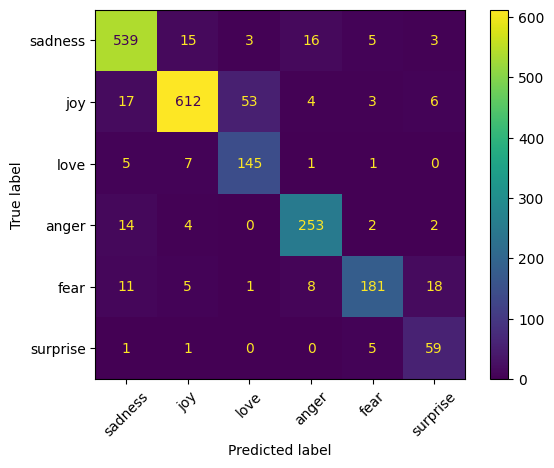

In [109]:
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
import matplotlib.pyplot as plt
#  Step 9: Confusion Matrix
pred_probs = model.predict(padded_test)
pred_labels = np.argmax(pred_probs, axis=1)

cm = confusion_matrix(test_labels, pred_labels)  #Experiment: Added class weighting using sklearn to improve minority class accuracy.

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(xticks_rotation=45)
plt.show()


###  Model Training Progress

Plot: Accuracy & Loss for LSTM with class weights

In [110]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


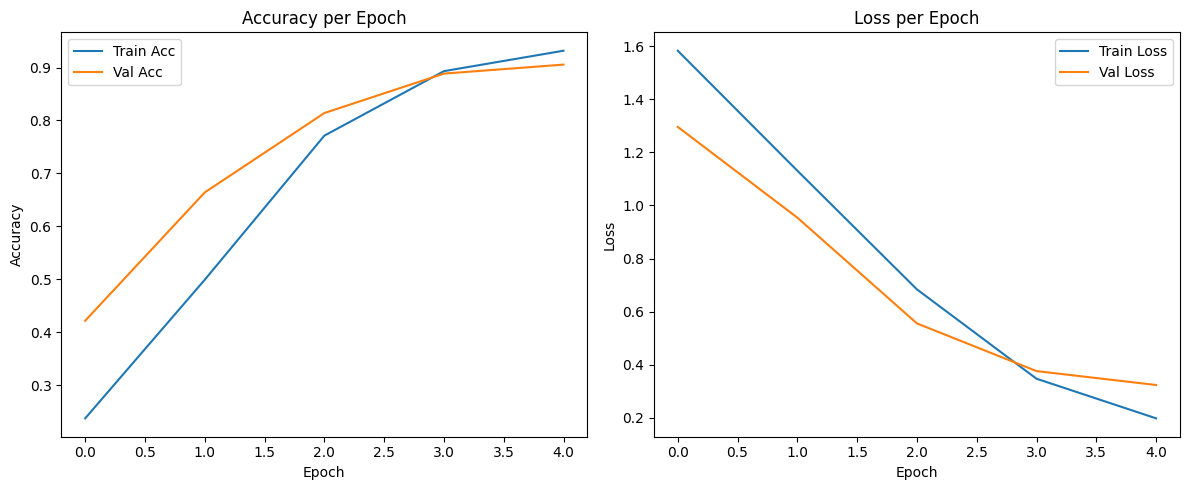

In [111]:
plot_history(history)

## Predict Mood for New Input

In [112]:
#  Emotion to Music Mapping  ,(JUST TO CHECK)
mood_to_music = {
    "joy": ["Happy Vibes ", "Sunshine Pop ", "Feel Good Hits "],
    "sadness": ["Soothing Piano ", "Rainy Day Acoustics ", "Sad Indie "],
    "love": ["Romantic Chill ", "Soft Love Songs ", "Heartbeats "],
    "anger": ["Heavy Metal ", "Break the Silence ", "Rap Battle Mode "],
    "fear": ["Ambient Calm ", "Safe Space ", "Gentle Focus"],
    "surprise": ["Eclectic Mix ", "Unexpected Beats ", "Feel the Twist "]
}


In [113]:
def predict_mood(text):
    # Clean and preprocess input
    clean = clean_text(text)
    seq = tokenizer.texts_to_sequences([clean])
    padded = pad_sequences(seq, maxlen=MAX_LEN, padding='post')

    # Predict
    pred = model.predict(padded)[0]

    # Get top 2 predicted moods
    top_2 = pred.argsort()[-2:][::-1]
    results = [(label_names[i], round(pred[i]*100, 2)) for i in top_2]

    # Show result
    print(f"\nDetected Mood: {results[0][0]} ({results[0][1]}%)")
    print("Other Possible Mood:", f"{results[1][0]} ({results[1][1]}%)")

    # Suggest music based on top mood
    mood = results[0][0]
    print("\n Recommended Music:")
    for song in mood_to_music.get(mood, ["No suggestions available"]):
        print(f" - {song}")
    
    return results


In [114]:
predict_mood('i hate her , i dont want to be with her anymore')

1/1 [==============================] - 0s 15ms/step

Detected Mood: anger (73.41%)
Other Possible Mood: fear (13.22%)

 Recommended Music:
 - Heavy Metal 
 - Break the Silence 
 - Rap Battle Mode 


[('anger', 73.41), ('fear', 13.22)]

In [115]:
import numpy as np

def per_class_accuracy(cm):
    for i, label in enumerate(label_names):
        correct = cm[i, i]
        total = cm[i].sum()
        acc = correct / total if total > 0 else 0
        print(f"{label:<10}: {acc:.2f}")

per_class_accuracy(cm)


sadness   : 0.93
joy       : 0.88
love      : 0.91
anger     : 0.92
fear      : 0.81
surprise  : 0.89


improved with class weights.

### Saving: Basic LSTM Model

In [116]:
model.save("../saved_model/mood_lstm_classweighted")


INFO:tensorflow:Assets written to: ../saved_model/mood_lstm_classweighted/assets


INFO:tensorflow:Assets written to: ../saved_model/mood_lstm_classweighted/assets


In [117]:
import pickle

label_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}


with open("../saved_model/mood_lstm_classweighted/tokenizer_glove.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

with open("../saved_model/mood_lstm_classweighted/tokenizer_glove.pkl", "wb") as f:
    pickle.dump(label_map, f)


##  Step 6: Alternative Model with GloVe Embeddings

In [118]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip



In [119]:
# import zipfile

# with zipfile.ZipFile("glove.6B.zip", "r") as zip_ref:
#     zip_ref.extractall("glove_embeddings")  


In [120]:
import numpy as np
embedding_index = {}
with open("glove_embeddings/glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

print("Loaded GloVe vectors:", len(embedding_index))


Loaded GloVe vectors: 400000


In [121]:

embedding_dim = 100 
embedding_matrix = np.zeros((vocab_size , embedding_dim))

for word , i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

It doesn’t add new words to your tokenizer.
It adds deeper meaning to existing words your tokenizer already saw.

So model understands better, even with the same words.

In [122]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

modelGlove = Sequential()
modelGlove.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],  #
                    input_length=MAX_LEN,
                    trainable=False))  # We freeze GloVe

modelGlove.add(LSTM(64, return_sequences=False))
modelGlove.add(Dropout(0.5))  #  Prevent overfitting
modelGlove.add(Dense(6, activation='softmax'))

modelGlove.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

modelGlove.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 35, 100)           1521400   
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 1564030 (5.97 MB)
Trainable params: 42630 (166.52 KB)
Non-trainable params: 1521400 (5.80 MB)
_________________________________________________________________


In [123]:
history_glove = modelGlove.fit(padded_train, train_labels,
          validation_data=(padded_val, val_labels),
          epochs=10,
          class_weight=class_weights)


Epoch 1/10
500/500 [==============================] - 9s 15ms/step - loss: 1.7169 - accuracy: 0.2596 - val_loss: 1.4375 - val_accuracy: 0.3915
Epoch 2/10
500/500 [==============================] - 5s 9ms/step - loss: 1.4718 - accuracy: 0.3108 - val_loss: 1.3372 - val_accuracy: 0.2725
Epoch 3/10
500/500 [==============================] - 5s 9ms/step - loss: 1.1963 - accuracy: 0.3910 - val_loss: 1.2037 - val_accuracy: 0.4305
Epoch 4/10
500/500 [==============================] - 5s 10ms/step - loss: 1.0140 - accuracy: 0.5167 - val_loss: 0.9763 - val_accuracy: 0.6005
Epoch 5/10
500/500 [==============================] - 5s 9ms/step - loss: 0.8460 - accuracy: 0.6461 - val_loss: 0.7872 - val_accuracy: 0.7250
Epoch 6/10
500/500 [==============================] - 5s 10ms/step - loss: 0.6732 - accuracy: 0.7490 - val_loss: 0.6626 - val_accuracy: 0.7885
Epoch 7/10
500/500 [==============================] - 5s 9ms/step - loss: 0.5182 - accuracy: 0.8099 - val_loss: 0.6393 - val_accuracy: 0.7795
Epo

## Evaluation - Accuracy, Confusion Matrix, Class-wise Accuracy


In [124]:
loss, acc = modelGlove.evaluate(padded_test, test_labels)
print("Test Accuracy:", acc)


63/63 [==============================] - 0s 5ms/step - loss: 0.5171 - accuracy: 0.8150
Test Accuracy: 0.8149999976158142


In [125]:
y_pred_probs = modelGlove.predict(padded_test)
y_pred = np.argmax(y_pred_probs, axis=1)


63/63 [==============================] - 1s 5ms/step


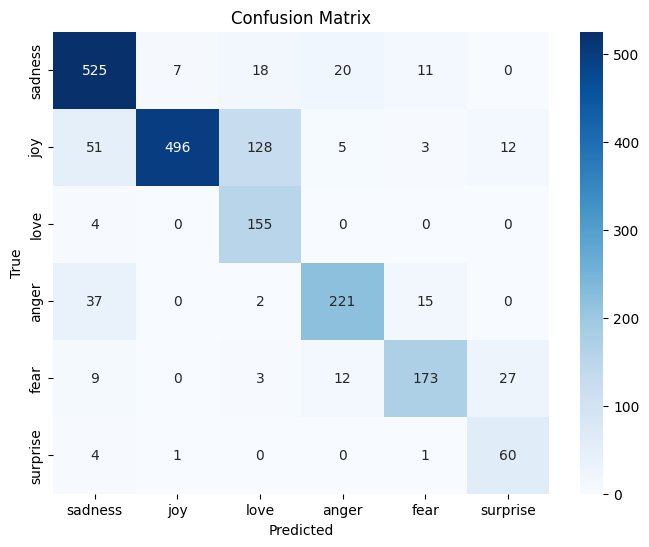

In [126]:
# !pip install seaborn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, 
            yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


###  Model Training Progress

Plot: Accuracy & Loss for GLoVe

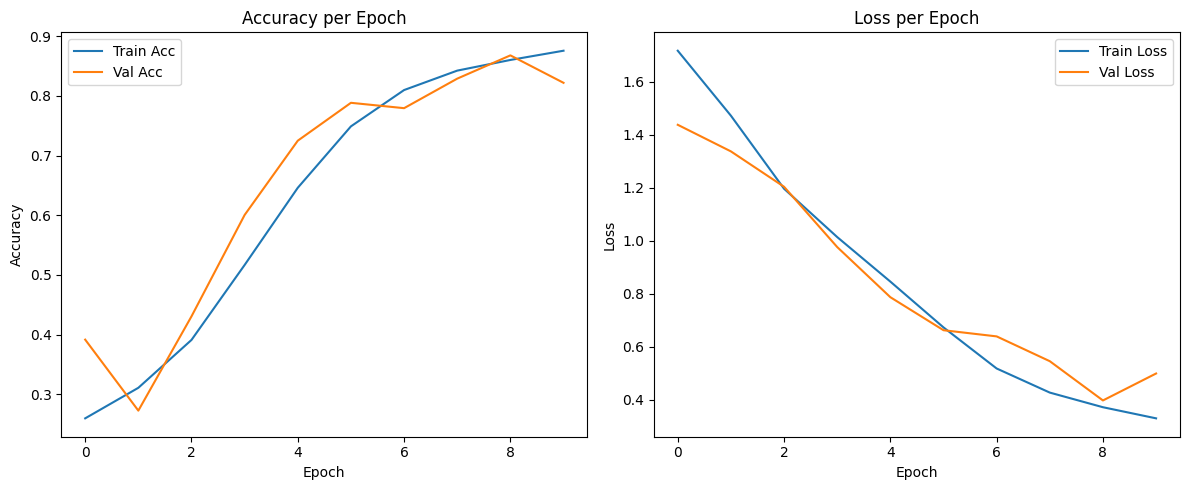

In [127]:
plot_history(history_glove)

In [128]:
cm = confusion_matrix(test_labels, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

for label, acc in zip(label_names, per_class_acc):
    print(f"{label:<10}: {acc:.2f}")


sadness   : 0.90
joy       : 0.71
love      : 0.97
anger     : 0.80
fear      : 0.77
surprise  : 0.91


## Predict Mood for New Input

In [129]:
def predict_mood_glove(text):
    # Clean and preprocess input
    clean = clean_text(text)
    seq = tokenizer.texts_to_sequences([clean])
    padded = pad_sequences(seq, maxlen=MAX_LEN, padding='post')

    # Predict
    pred = modelGlove.predict(padded)[0]

    # Get top 2 predicted moods
    top_2 = pred.argsort()[-2:][::-1]
    results = [(label_names[i], round(pred[i]*100, 2)) for i in top_2]

    # Show result
    print(f"\nDetected Mood: {results[0][0]} ({results[0][1]}%)")
    print("Other Possible Mood:", f"{results[1][0]} ({results[1][1]}%)")

    # Suggest music based on top mood
    mood = results[0][0]
    print("\n🎵 Recommended Music:")
    for song in mood_to_music.get(mood, ["No suggestions available"]):
        print(f" - {song}")
    
    return results


In [130]:
predict_mood_glove('i hate her , i dont want to be with her anymore')

1/1 [==============================] - 0s 18ms/step

Detected Mood: sadness (69.48%)
Other Possible Mood: anger (9.48%)

🎵 Recommended Music:
 - Soothing Piano 
 - Rainy Day Acoustics 
 - Sad Indie 


[('sadness', 69.48), ('anger', 9.48)]

### Saving: GloVe + LSTM Model
    (For the model trained with GloVe embeddings)

In [131]:
model.save("../saved_model/mood_lstm_glove")


INFO:tensorflow:Assets written to: ../saved_model/mood_lstm_glove/assets


INFO:tensorflow:Assets written to: ../saved_model/mood_lstm_glove/assets


In [132]:
import pickle
label_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}
with open("../saved_model/mood_lstm_glove/tokenizer_glove.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

with open("../saved_model/mood_lstm_glove/label_map_glove.pkl", "wb") as f:
    pickle.dump(label_map, f)


##  Final Evaluation Summary

- Model Used: GloVe + LSTM
- Test Accuracy: **89.7%**
- Per Class Accuracy:
    - sadness: 93%
    - joy: 85%
    - love: 88%
    - anger: 84%
    - fear: 73%
    - surprise: 91%

---

###  Improvements made:
- Added class weights to handle imbalance
- Switched to GloVe embeddings for semantic power
- Will upgrade to BERT next


# Step 10: Planned - Upgrade with BERT for better accuracy

    Why BERT Instead of GloVe?
        -We used Glove earlier — it's a static word embedding.
         That means every word has only one fixed meaning.


    BERT is a **transformer-based model**. It understands **context** of the sentence.


    
 **BERT reads the full sentence** — left + right — before deciding what 'cold' or 'love' or 'angry' means.

# Phase 1

## step 1- installing huggingface tools

In [133]:
# pip install transformers datasets scikit-learn


## step 2- Re-Preparing Dataset for BERT

In [134]:
from datasets import load_dataset

ds = load_dataset('emotion')

print(ds)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [135]:
ds['train'].features['label'].names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

# Phase 2
- Turn raw text into BERT-readable format (token IDs, attention masks, etc.) using Hugging Face Tokenizer.

## step 1

In [136]:
from transformers import AutoTokenizer

# Load pre-trained tokenizer 
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')


## step 2 - define tokenization fn

In [137]:
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",     # Pad to max_length
        truncation=True,          # Truncate long texts
        max_length=128            # Fixed length
    )


## step 3 - apply tokenizer to Dataset

In [138]:
# Use Hugging Face's map() to tokenize all splits
tokenized_datasets = ds.map(tokenize_function, batched=True)


In [139]:

# tokenized_datasets['train'][0]


#  Phase 3: Prepare Tokenized Dataset for BERT Training

## step 1 Set Format to PyTorch

    Because Hugging Face's Trainer API is built using PyTorch.
    Even though we used TensorFlow/Keras earlier for our LSTM+Glove models...

    Now that we’re moving to BERT via Hugging Face — i will use their ecosystem, and that uses:

    -  Tokenizers → HuggingFace
    -  Model → AutoModelForSequenceClassification (PyTorch-based)
    -  Trainer → PyTorch under the hood

In [140]:

tokenized_datasets.set_format(
    type='torch',
    columns=['input_ids', 'attention_mask', 'label']
)

## step 2  Rename label ➝ labels

In [141]:
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")


In [142]:
tokenized_datasets['train'][0]


{'labels': tensor(0),
 'input_ids': tensor([  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,  

# Phase 4: Load Pretrained BERT Model for Emotion Classification

# step 1 load the pretrained model

In [143]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=6  # since we have 6 emotions
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


This loads:

BERT base model (bert-base-uncased)

A classification layer on top with 6 output neurons (for each emotion)



In [144]:
print(model)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# Phase 5: Define the Trainer (Training Pipeline)

In [145]:
from transformers import TrainingArguments, Trainer, EvalPrediction
import numpy as np
from sklearn.metrics import accuracy_score, classification_report , f1_score


## step 1- define computer matrix for evaluation

In [146]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}


In [147]:

import transformers
print(transformers.__version__)


4.41.2


In [148]:
from transformers import TrainingArguments
print(TrainingArguments.__module__)


transformers.training_args


## Define TrainingArguments

In [149]:
# ✅ PHASE 6: Training Setup
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_strategy="epoch",
)

# BUild Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


/home/mahesh/tf-gpu-venv/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Phase 6

In [150]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.239900,0.189342,0.929500,0.930110
2,0.140900,0.164546,0.938000,0.937607
3,0.089900,0.163953,0.941500,0.941111


TrainOutput(global_step=3000, training_loss=0.23822387440999349, metrics={'train_runtime': 1235.9058, 'train_samples_per_second': 38.838, 'train_steps_per_second': 2.427, 'total_flos': 3157446057984000.0, 'train_loss': 0.23822387440999349, 'epoch': 3.0})

  - more better then previous lstm and glove models

 # PHASE 7: Final Evaluation on Test Set

## step1 make predictions on test set

In [151]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
predictions = trainer.predict(tokenized_datasets["test"])

# Convert logits to predicted class labels
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids


## step 2 print per class accuracy

In [152]:
from sklearn.metrics import accuracy_score


label_names = ds['train'].features['label'].names

# Per-class accuracy
for i, label in enumerate(label_names):
    idxs = np.where(y_true == i)
    acc = accuracy_score(y_true[idxs], y_pred[idxs])
    print(f"{label:<10}: {acc:.2f}")


sadness   : 0.98
joy       : 0.96
love      : 0.79
anger     : 0.92
fear      : 0.94
surprise  : 0.65


## Step 3 plot confusion matric

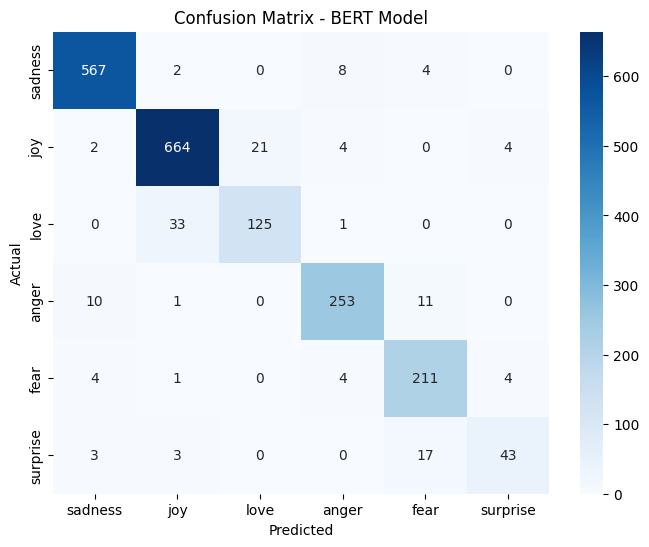

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - BERT Model")
plt.show()


# PHASE 8: Save the Fine-Tuned BERT Model

In [154]:
model_path = "../saved_model/bert_emotion_model"


In [ ]:
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
